In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class MyLifetimePdf:


    #............................
    #Constructors
    def __init__(self, tau, limlo = 0.0, limhi = 10.0):
        self.tau = tau #lifetime to model
        self.limlo = limlo #lower limit to sample from
        self.limhi = limhi #upper limit to sample from
        
        #creating variables for sampling
        self.t = np.arange(limlo,limhi,0.01)#create probability based sampling space
        self.pdf = self.evaluate(self.t)#calc probabilities
        self.pdf = self.pdf/np.sum(self.pdf)#normalize pdf
        self.max = np.max(self.pdf)
 
    #............................
    #Method to return value of probability for lifetime t
    def evaluate(self, t):
         return np.exp(-t/self.tau)/self.tau


    #............................
    #Method to return expected value of probability of lifetime tau
    def prob_real(self):
        return self.evaluate(self.tau)
    
    
    #............................
    #Method to return a random number with a exponential distribution in range t = limlo to limhi
    def __next__( self ):
        return np.random.choice(self.t,p = self.pdf)
    
    
    #............................
    #Method to do numerical integration
    #This is written in a very simplistic way.
    

    def integralNumericBox( self, ilo, ihi ):

        npoints = 10000000
        ninside = 0
        lo = float(ilo)
        hi = float(ihi)

        for i in range(npoints):
            if(i%1000000 == 0):
                print(i,' done')
            x = lo + np.random.uniform()*(hi-lo)
            y = np.random.uniform()*self.max
            if( y < self.evaluate(x)): ninside = ninside+1

        Atot = (hi-lo)*self.max
        eff = float(ninside)/float(npoints)
        
        #Area
        Area = Atot * eff
        #Binomial error
        Error = Atot*math.sqrt(eff*(1-eff)/npoints)

        return Area, Error
            
    #............................
    #Method to do numerical integration
    #This is written in a very simplistic way.
            
            
    def integralNumericAvg( self, ilo, ihi ):
        
        npoints = 10000000
        ninside = 0
        lo = float(ilo)
        hi = float(ihi)
        sum = 0.
        
        for i in range(npoints):
            if(i%1000000 == 0):
                print(i,' done')
            x = lo + np.random.uniform()*(hi-lo)
            sum+= self.evaluate(x)
        
        Area = (hi-lo)*sum/npoints
        Error = Area * math.sqrt(npoints)/npoints
        
        return Area, Error
    


    #............................
    #Method to do analytic integration
    # This is lazt version wiuch assumed limits are very large
    # So lo and hi are ignored

    def integralAnalytic( self, lo, hi ):
        integral  = 1.
        #integral = self.width*math.sqrt(2.0*math.pi )
        return integral
    
def plothist(gpts,sim):
    x = sim.t
    y = sim.evaluate(x)
    plt.figure()
    plt.hist(gpts,density=True,bins=int(np.sqrt(len(gpts))))
    plt.plot(x,y)
    plt.show()
    return

def mapShape( shape, lolimit, hilimit, steps ):
    y = []
    x = []
    increment = (hilimit-lolimit)/steps
    for i in range( steps ):
        t = lolimit+i*increment
        x.append(t)
        y.append(shape.evaluate(t))
    return x,y

def t_est(data):
    if(len(data.shape) == 1):
        return np.mean(data)
    else:
        return np.mean(data,axis = 1)

In [3]:
points = 1000
bins = int(np.sqrt(points))
tau = 2.2
limlo = 0.0
limhi = 10.0

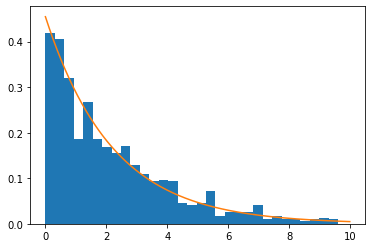

In [4]:
simulator = MyLifetimePdf(tau, limlo = limlo, limhi = limhi)
data1 = []
for i in range(points):
    data1.append(next(simulator))
data1 = np.array(data1)
plothist(data1,simulator)

In [5]:
print('Estimated lifetime ~ ',np.round(t_est(data1),decimals = 2))

Estimated lifetime ~  2.15


In [6]:
simulator = MyLifetimePdf(tau, limlo = limlo, limhi = limhi)
nsamples = 500
data500 = np.zeros((500,1000))
for i in range(nsamples):
    if(i%100 == 0):
        print(i,' experiments created')
    for j in range(points):
        data500[i][j] = next(simulator)
data500.shape   

0  experiments created
100  experiments created
200  experiments created
300  experiments created
400  experiments created


(500, 1000)

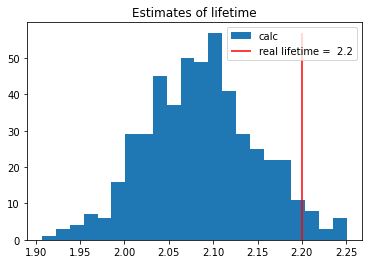

In [7]:
t_ests = t_est(data500)
hist, _ , _= plt.hist(t_ests,bins = int(np.sqrt(nsamples)), label = 'calc')
plt.vlines(tau,ymin = 0,ymax = np.max(hist),color = 'r',label = 'real lifetime =  '+str(tau))
plt.legend()
plt.title('Estimates of lifetime')
plt.show()

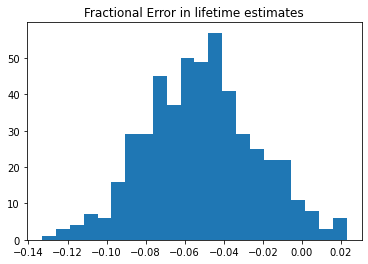

In [17]:
fracerrs = (t_ests - tau)/tau
plt.hist(fracerrs,bins = int(np.sqrt(nsamples)))
plt.title('Fractional Error in lifetime estimates')
plt.show()

In [18]:
AvgFracErr = np.mean(fracerrs)
print('Average fractional error: ',np.round(AvgFracErr,decimals = 2))

Average fractional error:  -0.05


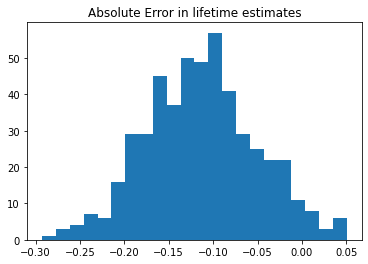

In [19]:
errs = (t_ests - tau)
plt.hist(errs,bins = int(np.sqrt(nsamples)))
plt.title('Absolute Error in lifetime estimates')
plt.show()

In [25]:
AvgErr = np.mean(errs)
std = np.std(t_ests)
print('Average error(bias) = ',np.round(AvgErr,decimals = 2))
print('fraction bias: ',np.round(AvgErr/tau, decimals = 2))
print('Precision: ', np.round(std,decimals = 2))

Average error(bias) =  -0.11
fraction bias:  -0.05
Precision:  0.06


Yes, the method is biased. Negative bias of ~ 5%. This is due to the missing tail-end of the function(ie. cutting off the function at t = 10.0).


-------------------------------------------------------------------------------

---

Below is early testing

In [2]:
def ptau(t, tau):
    return np.exp(-t/tau)/tau

def gen_curve(tau,xmin=0.0,xmax=10.0,dx=0.1):
    t = np.arange(xmin,xmax,dx)
    return t,ptau(t,tau)

def gen_points(tau,N=1000):
    gpts = np.random.exponential(scale=tau,size=N)
    ax = len(gpts.shape)-1
    return gpts,np.mean(gpts,axis = ax)

def plothist(gpts,tau):
    x,y = gen_curve(tau,xmin=np.min(gpts),xmax=np.max(gpts))
    plt.figure()
    plt.hist(gpts,density=True,bins=int(np.sqrt(len(gpts))))
    plt.plot(x,y)
    plt.show()
    return

In [3]:
tau = 2.2
N = 1000

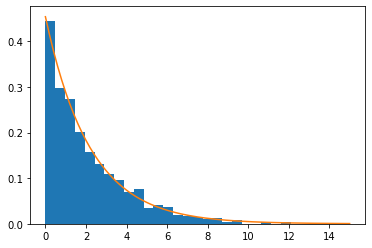

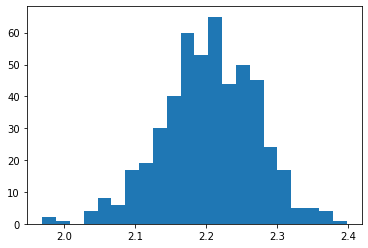

In [4]:
gpts,t_est = gen_points(tau,N=N)
plothist(gpts,tau)
num_samples = 500
gpts,t_est = gen_points(tau, N=(500,N))

plt.hist(t_est,bins=int(np.sqrt(len(t_est))))
plt.show()

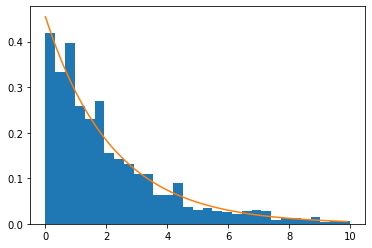

In [5]:
t = np.arange(0,10,0.01)
p = ptau(t,tau)
p = p/np.sum(p)
gpts = np.random.choice(t,size=N,p=p)
plothist(gpts,tau)